In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


import os

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
train_data.shape

(165034, 14)

In [4]:
train_data.isnull().sum() # no null values 

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# EDA

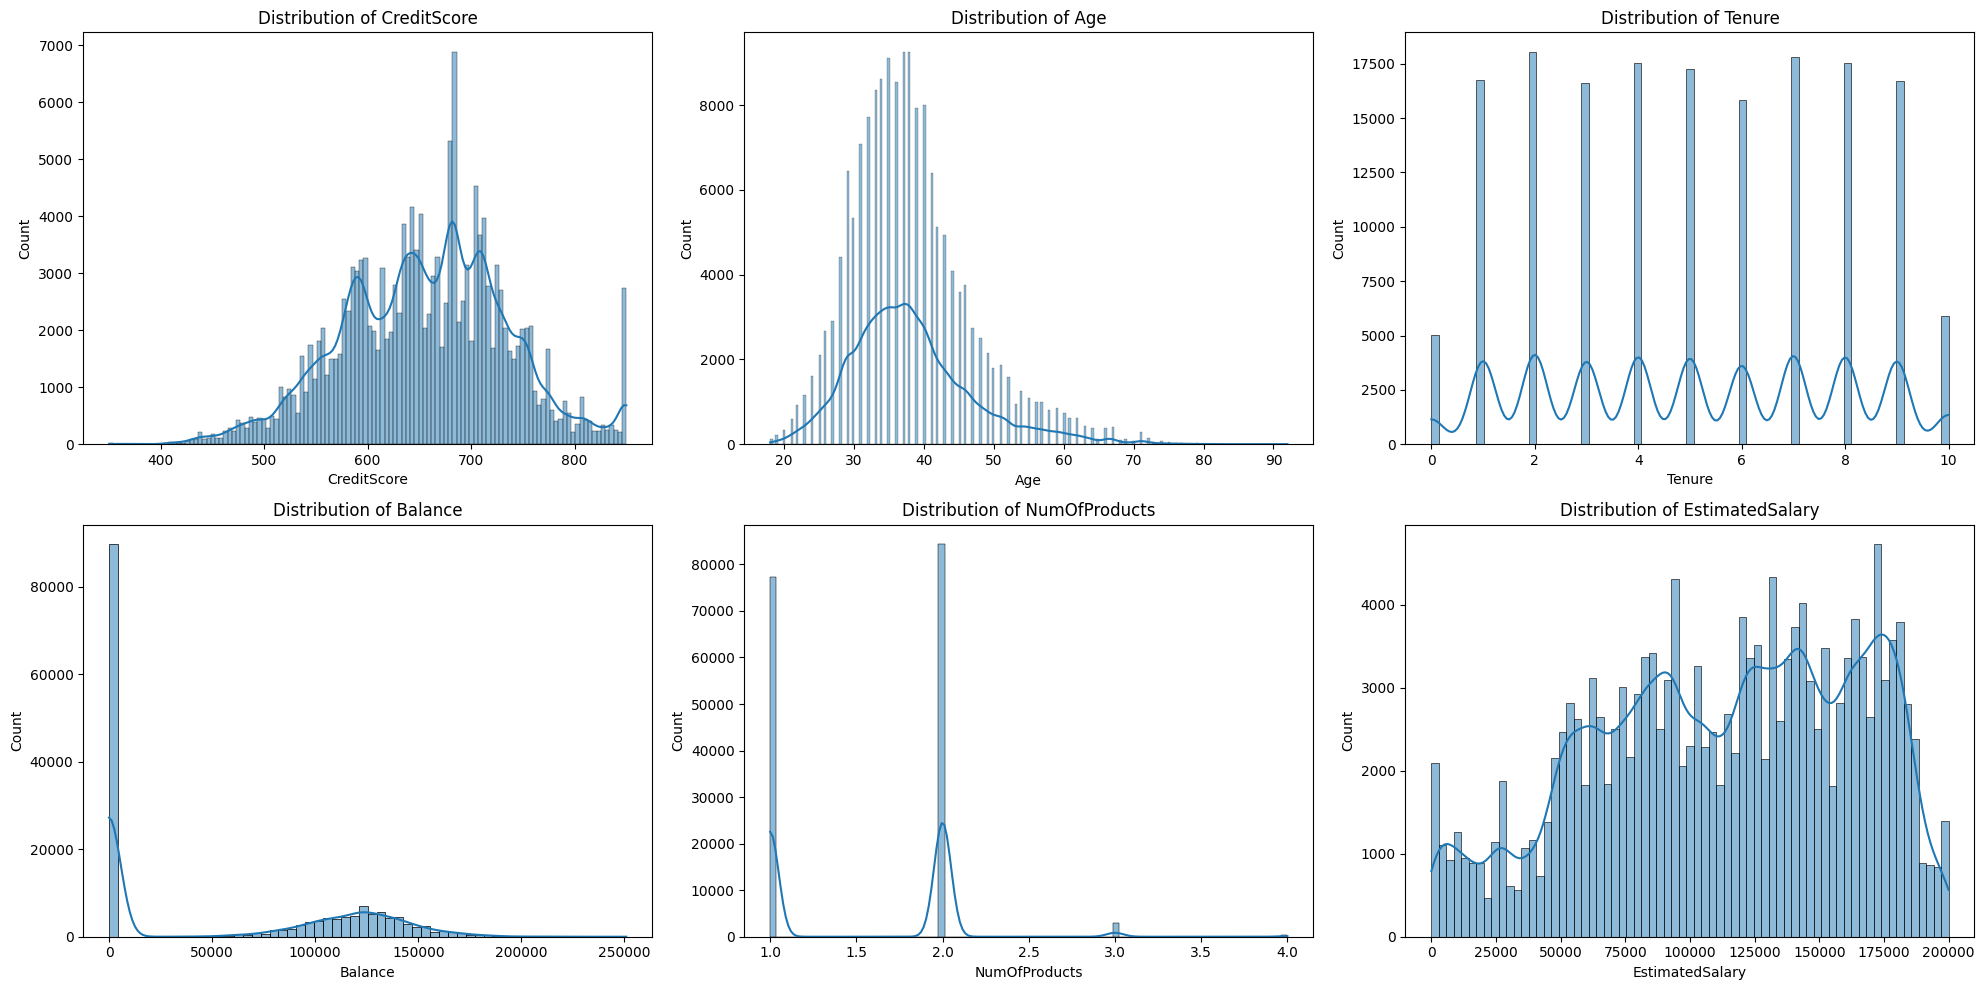

In [5]:
# Distribution Analysis
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


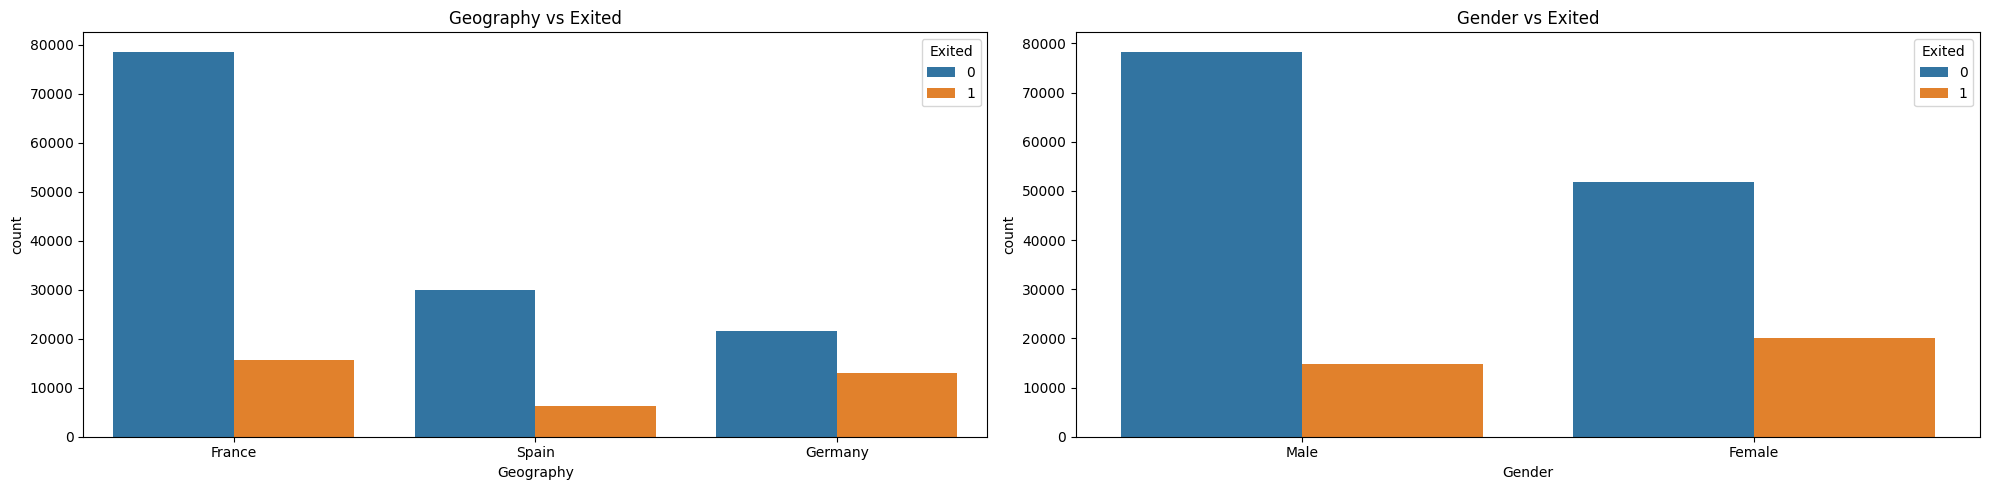

In [6]:
# Category Analysis
categorical_features = ['Geography', 'Gender']

plt.figure(figsize=(20, 5))
for i, feature in enumerate(categorical_features):
    plt.subplot(1, 2, i+1)
    sns.countplot(data=train_data, x=feature, hue='Exited')
    plt.title(f'{feature} vs Exited')
plt.tight_layout()
plt.show()

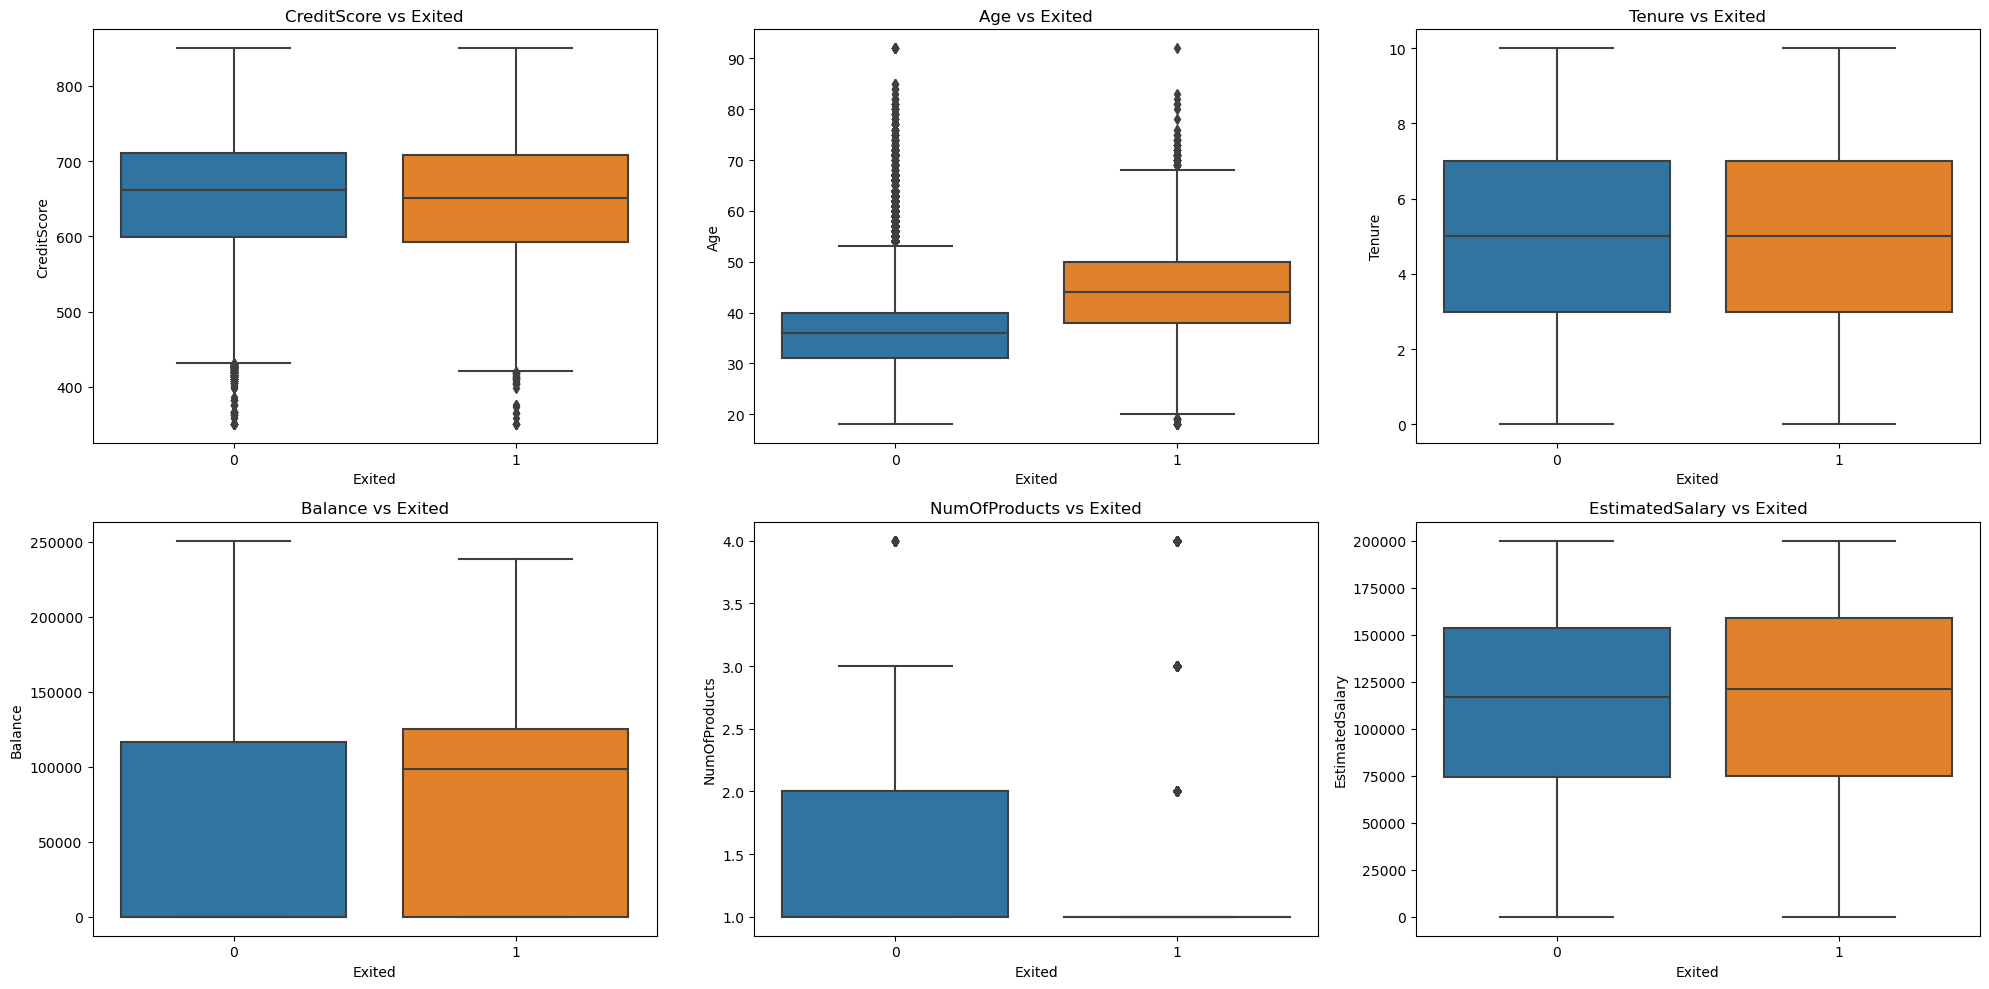

In [257]:
# Relationship Analysis
plt.figure(figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=train_data, x='Exited', y=feature)
    plt.title(f'{feature} vs Exited')
plt.tight_layout()
plt.show()


In [258]:
# # Pairplot
# sns.pairplot(train_data, hue='Exited', diag_kind='kde', markers=["o", "s"], plot_kws={'alpha': 0.5})
# plt.suptitle("Pairplot of Features", y=1.02)
# plt.show()


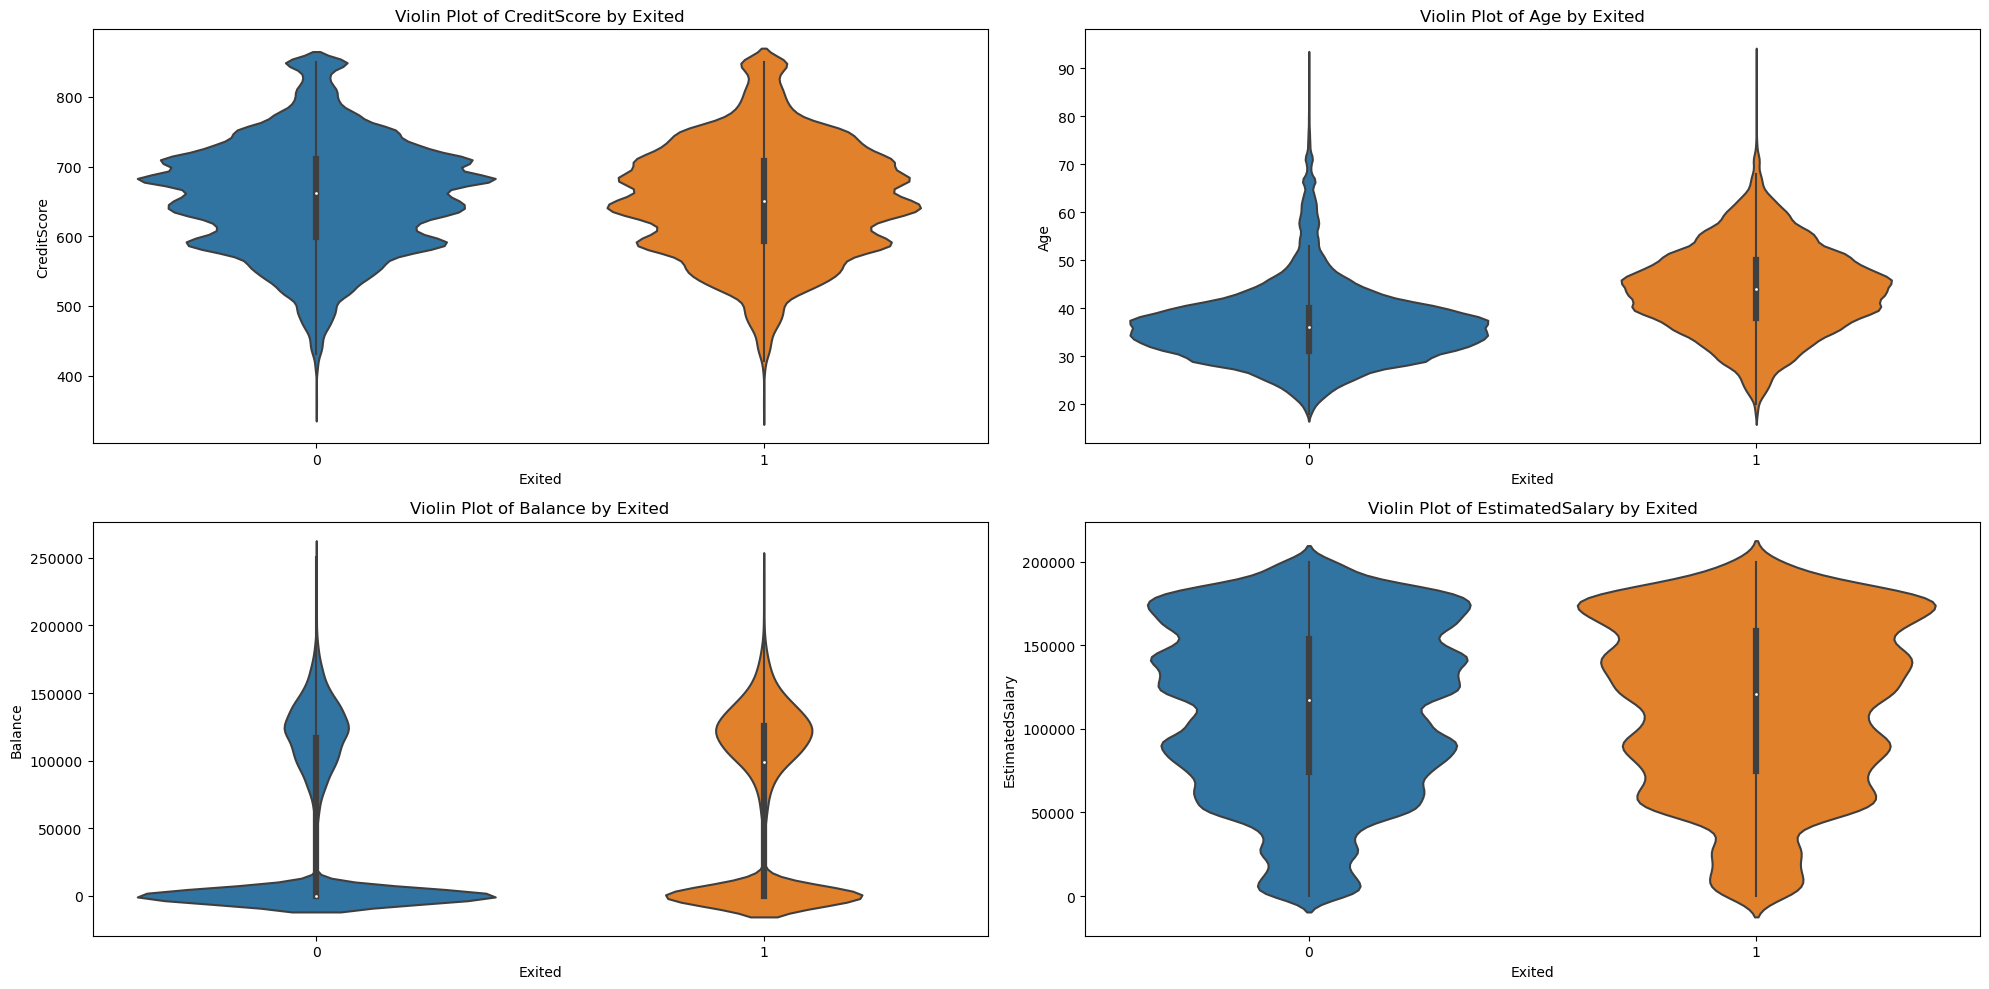

In [259]:
# Violin Plots
plt.figure(figsize=(20, 10))
for i, feature in enumerate(['CreditScore', 'Age', 'Balance', 'EstimatedSalary']):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='Exited', y=feature, data=train_data)
    plt.title(f'Violin Plot of {feature} by Exited')
plt.tight_layout()
plt.show()

In [260]:
# # Swarm Plots
# plt.figure(figsize=(20, 10))
# for i, feature in enumerate(['CreditScore', 'Age', 'Balance', 'EstimatedSalary']):
#     plt.subplot(2, 2, i+1)
#     sns.swarmplot(x='Exited', y=feature, data=train_data, alpha=0.5)
#     plt.title(f'Swarm Plot of {feature} by Exited')
# plt.tight_layout()
# plt.show()

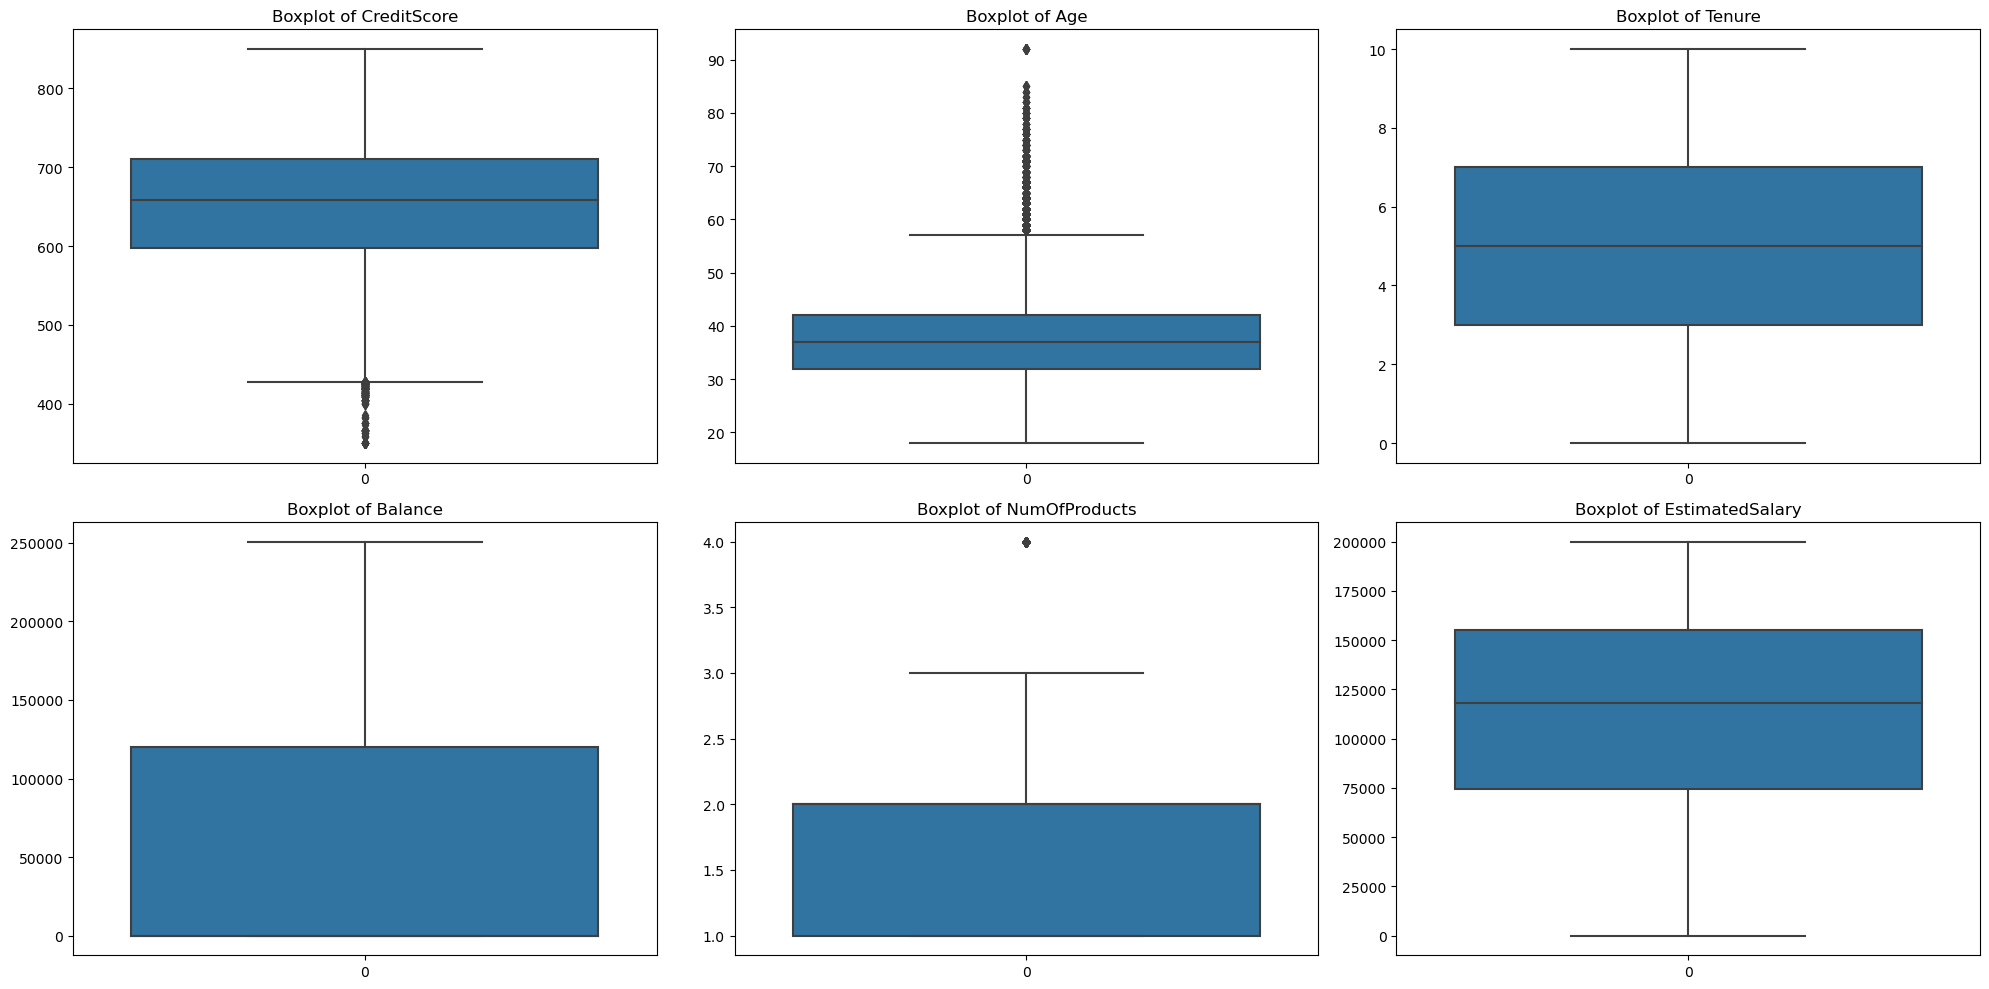

In [261]:

# Outlier Detection
plt.figure(figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(train_data[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

# Features Extraction

In [7]:
def vectorizer_tfidk(df):
    from sklearn.feature_extraction.text import TfidfVectorizer
    import gc


    # we return same text, because here we dont do any tokenization because surnames are usually not sentences and regular english language
    def dummy(text):
        return text

    vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
        tokenizer = dummy,
        preprocessor = dummy,
        token_pattern = None, 
        strip_accents='unicode',
        max_features=1000
    )

    vectorizer.fit(df["Surname"])

    vocab = vectorizer.vocabulary_

    vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                                analyzer = 'word',
                                tokenizer = dummy,
                                preprocessor = dummy,
                                token_pattern = None, strip_accents='unicode', max_features=1000
                                )



    surnames = vectorizer.fit_transform(df["Surname"])

    # we free the space by removing reference to the object vectorizer and use garbage collector
    # to remove the unused space from the memory
    del vectorizer
    gc.collect()
    return surnames
surnames = vectorizer_tfidk(train_data)


In [8]:
len(surnames.toarray()[0]), len(surnames.toarray())


(1000, 165034)

In [9]:
def PCA_Dimensionality_reduction(df):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=10)
    tfidf_train_pca = pca.fit_transform(surnames.toarray())

    pca_columns = [f'Surname_PCA_{i+1}' for i in range(10)]
    df_surnames = pd.DataFrame(tfidf_train_pca, columns=pca_columns)
    return df_surnames
df_surnames = PCA_Dimensionality_reduction(surnames)
df_surnames.head()

,Surname_PCA_1,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10
0,0.422144,0.078566,0.055907,0.004708,0.007231,0.005387,0.017066,-0.004317,0.017275,0.010160
1,0.106232,0.008077,-0.005564,-0.004629,-0.018922,-0.021290,0.058632,-0.023595,0.016787,0.002002
2,-0.034278,-0.028976,-0.042958,-0.012764,-0.029205,-0.021920,-0.015534,0.027379,-0.038374,-0.003500
3,-0.034649,-0.030706,-0.046873,-0.014107,-0.044499,-0.032514,-0.028266,0.058462,-0.062967,-0.053783
4,-0.026012,-0.033249,-0.029035,-0.015103,-0.044035,-0.040656,-0.042131,0.026610,-0.085706,-0.126292


In [10]:
def concat_dataframes(df, df_surnames):    
    df.reset_index(drop=True, inplace=True)
    df_surnames.reset_index(drop=True, inplace=True)

    df = pd.concat([df, df_surnames], axis="columns")
    return df
train_data = concat_dataframes(train_data, df_surnames)
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Surname_PCA_1,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0.422144,0.078566,0.055907,0.004708,0.007231,0.005387,0.017066,-0.004317,0.017275,0.010160
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0.106232,0.008077,-0.005564,-0.004629,-0.018922,-0.021290,0.058632,-0.023595,0.016787,0.002002
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,-0.034278,-0.028976,-0.042958,-0.012764,-0.029205,-0.021920,-0.015534,0.027379,-0.038374,-0.003500
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,-0.034649,-0.030706,-0.046873,-0.014107,-0.044499,-0.032514,-0.028266,0.058462,-0.062967,-0.053783
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,-0.026012,-0.033249,-0.029035,-0.015103,-0.044035,-0.040656,-0.042131,0.026610,-0.085706,-0.126292


In [11]:
def droping_entitites(df):
    df.drop(columns=["id", "CustomerId", "Surname"], inplace=True)
    return df
train_data = droping_entitites(train_data)
train_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_1,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,...,0.422144,0.078566,0.055907,0.004708,0.007231,0.005387,0.017066,-0.004317,0.017275,0.010160
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,...,0.106232,0.008077,-0.005564,-0.004629,-0.018922,-0.021290,0.058632,-0.023595,0.016787,0.002002
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,...,-0.034278,-0.028976,-0.042958,-0.012764,-0.029205,-0.021920,-0.015534,0.027379,-0.038374,-0.003500
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,...,-0.034649,-0.030706,-0.046873,-0.014107,-0.044499,-0.032514,-0.028266,0.058462,-0.062967,-0.053783
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,...,-0.026012,-0.033249,-0.029035,-0.015103,-0.044035,-0.040656,-0.042131,0.026610,-0.085706,-0.126292


In [12]:
def encode_categorial_values(df):    
    from sklearn import preprocessing 
    label_encoder = preprocessing.LabelEncoder() 
    # Encode labels in column 'species'. 
    df['Geography']= label_encoder.fit_transform(df['Geography']) 
    df['Gender']= label_encoder.fit_transform(df['Gender']) 
    df['Geography'].unique() 
    return df
train_data = encode_categorial_values(train_data)
train_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_1,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,...,0.422144,0.078566,0.055907,0.004708,0.007231,0.005387,0.017066,-0.004317,0.017275,0.010160
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,...,0.106232,0.008077,-0.005564,-0.004629,-0.018922,-0.021290,0.058632,-0.023595,0.016787,0.002002
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,...,-0.034278,-0.028976,-0.042958,-0.012764,-0.029205,-0.021920,-0.015534,0.027379,-0.038374,-0.003500
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,...,-0.034649,-0.030706,-0.046873,-0.014107,-0.044499,-0.032514,-0.028266,0.058462,-0.062967,-0.053783
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,...,-0.026012,-0.033249,-0.029035,-0.015103,-0.044035,-0.040656,-0.042131,0.026610,-0.085706,-0.126292


In [13]:
def add_new_features(df):
    df['Geo_Gender'] = df['Geography'] + df['Gender'] + 10
    df['AgeGroup'] = df['Age'] // 10 * 10
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['QualityOfBalance'] = pd.cut(df['Balance'], bins=[-1,100,1000,10000,50000,1000000], labels=['VeryLow', 'Low', 'Medium','High','Highest'])
    df['QualityOfBalance'].replace(['VeryLow', 'Low', 'Medium','High','Highest'],[0,1,2,3,4], inplace=True)
    df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    df['CreditScoreTier'] = pd.cut(df['CreditScore'], bins=[0, 650, 750, 850], labels=['Low', 'Medium', 'High'])
    df['CreditScoreTier'].replace(['Low', 'Medium', 'High'],[0, 1, 2], inplace=True)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
    df['Customer_Status'] = df['Tenure'].apply(lambda x:0 if x < 2 else 1)
    return df
train_data=add_new_features(train_data)
train_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_10,Geo_Gender,AgeGroup,IsSenior,QualityOfBalance,Balance_to_Salary_Ratio,CreditScoreTier,IsActive_by_CreditCard,Products_Per_Tenure,Customer_Status
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,...,0.010160,11,30.0,0,0,0.000000,1,0.0,1.5,1
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,...,0.002002,11,30.0,0,0,0.000000,0,1.0,0.5,0
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,...,-0.003500,11,40.0,0,0,0.000000,1,0.0,5.0,1
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,...,-0.053783,11,30.0,0,4,1.760655,0,1.0,2.0,1
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,...,-0.126292,13,30.0,0,0,0.000000,1,1.0,2.5,1


In [14]:
train_data = train_data.astype({
    'QualityOfBalance': int,
    'CreditScoreTier': int
})

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CreditScore              165034 non-null  int64  
 1   Geography                165034 non-null  int64  
 2   Gender                   165034 non-null  int64  
 3   Age                      165034 non-null  float64
 4   Tenure                   165034 non-null  int64  
 5   Balance                  165034 non-null  float64
 6   NumOfProducts            165034 non-null  int64  
 7   HasCrCard                165034 non-null  float64
 8   IsActiveMember           165034 non-null  float64
 9   EstimatedSalary          165034 non-null  float64
 10  Exited                   165034 non-null  int64  
 11  Surname_PCA_1            165034 non-null  float64
 12  Surname_PCA_2            165034 non-null  float64
 13  Surname_PCA_3            165034 non-null  float64
 14  Surn

# Split Data

In [16]:
X = train_data.drop(columns = ["Exited"])
y = train_data[["Exited"]]

In [17]:
X.shape,y.shape

((165034, 29), (165034, 1))

In [18]:
def handling_imbalanced_dataset(X,y):
    smote_os = SMOTE(random_state = 42)
    X, y = smote_os.fit_resample(X, y)
    return X,y
X,y = handling_imbalanced_dataset(X,y)

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the resulting arrays
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (208180, 29)
X_test shape: (52046, 29)
y_train shape: (208180, 1)
y_test shape: (52046, 1)


# Train ML Model

In [318]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


# Initialize classifiers
classifiers = {
    #"Logistic Regression": LogisticRegression(),
    #"Decision Tree": DecisionTreeClassifier(),
    #"Random Forest": RandomForestClassifier(),
    #"Support Vector Machine": SVC(),
    #"K-Nearest Neighbors": KNeighborsClassifier(),
    #"Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(),
    "CatBoost" : CatBoostClassifier(verbose =100),
    "LGBM" : LGBMClassifier(),
}

# Train, cross-validate, and evaluate each classifier
for name, clf in classifiers.items():
    # Create a pipeline with standard scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    # Train the classifier
    pipeline.fit(X_train, y_train)
    
    # Perform k-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    print(f"{name} Cross-Validation Scores: {cv_scores}")
    print(f"{name} Mean Cross-Validation Score: {cv_scores.mean()}")
    
    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = roc_auc_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    
    # Generate classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:\n{report}")
    print("--------------------------------------")


XGBoost Cross-Validation Scores: [0.91308003 0.91392065 0.90921318 0.911687   0.91079835]

XGBoost Mean Cross-Validation Score: 0.9117398405226247

XGBoost Accuracy: 0.9135155380292802

XGBoost Classification Report:

              precision    recall  f1-score   support



           0       0.89      0.94      0.92     26008

           1       0.94      0.89      0.91     26038



    accuracy                           0.91     52046

   macro avg       0.91      0.91      0.91     52046

weighted avg       0.91      0.91      0.91     52046



--------------------------------------

Learning rate set to 0.100672

0:	learn: 0.5774871	total: 73.4ms	remaining: 1m 13s

100:	learn: 0.2195975	total: 5.58s	remaining: 49.7s

200:	learn: 0.2082976	total: 10.7s	remaining: 42.4s

300:	learn: 0.2022770	total: 15.8s	remaining: 36.6s

400:	learn: 0.1983211	total: 20.2s	remaining: 30.1s

500:	learn: 0.1942354	total: 24.2s	remaining: 24.2s

600:	learn: 0.1910476	total: 28.4s	remaining: 18.9s

700:

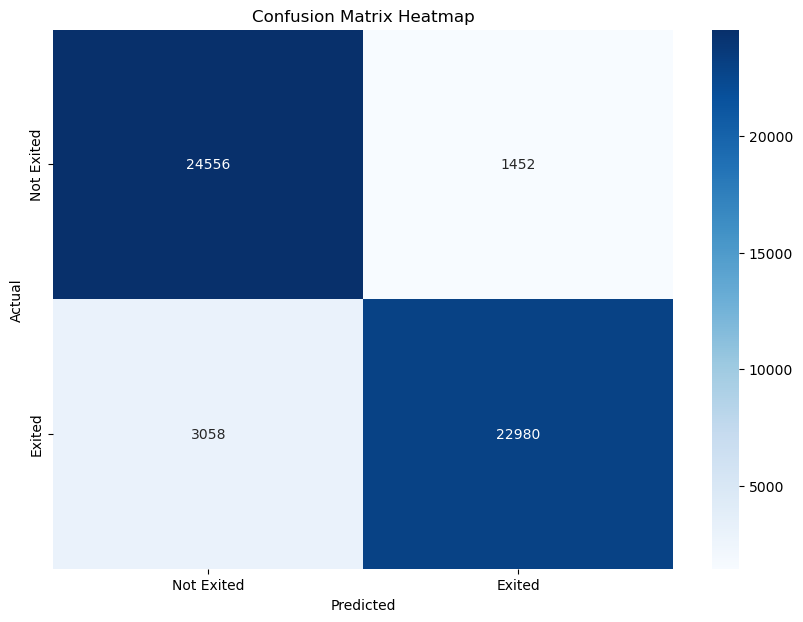

In [319]:
from sklearn.metrics import confusion_matrix
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Hyperparameter Tunning 

In [320]:
from sklearn.model_selection import GridSearchCV
models = {
    "XGBoost": xgb.XGBClassifier(tree_method="hist", device="cuda")
}

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [1500, 1000],  # number of trees
        'classifier__max_depth': [6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__colsample_bytree': [0.7, 1.0],
        'classifier__gamma': [0.1,0.3],
    }
}

best_models = {}
best_params = {}
best_scores = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create a pipeline with scaling and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[model_name],verbose=3)
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)
    
    # Store the best model, parameters, and score
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    
    print(f"Best Model for {model_name}: {best_models[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params[model_name]}")
    print(f"Best Score for {model_name}: {best_scores[model_name]}")

# Evaluate the best model on the test set
best_model = best_models["XGBoost"]
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


In [321]:
print(f"Best Model for {model_name}: {best_models[model_name]}")
print(f"Best Parameters for {model_name}: {best_params[model_name]}")
print(f"Best Score for {model_name}: {best_scores[model_name]}")


# Test Data with ML

In [24]:
ids = test_data["id"].to_list()
test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [25]:
surnames = vectorizer_tfidk(test_data)
df_surnames = PCA_Dimensionality_reduction(surnames)
test_data = concat_dataframes(test_data, df_surnames)
test_data = droping_entitites(test_data)
test_data = encode_categorial_values(test_data)
test_data=add_new_features(test_data)
test_data = test_data.astype({
    'QualityOfBalance': int,
    'CreditScoreTier': int
})
test_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_10,Geo_Gender,AgeGroup,IsSenior,QualityOfBalance,Balance_to_Salary_Ratio,CreditScoreTier,IsActive_by_CreditCard,Products_Per_Tenure,Customer_Status
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,...,-0.020940,10,20.0,0,0,0.000000,0,0.0,1.0,1
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,...,0.008805,10,40.0,0,0,0.000000,1,0.0,2.0,1
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,...,0.003741,10,30.0,0,0,0.000000,1,0.0,3.5,1
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,...,0.008352,11,30.0,0,0,0.000000,1,0.0,8.0,1
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,...,0.003741,12,30.0,0,4,0.869703,2,0.0,10.0,1


Choosed best model and parameters

In [324]:
# Initialize classifiers
classifiers = {
    "CatBoostClassifier": CatBoostClassifier(verbose =100, objective = 'Logloss',eval_metric = 'AUC',early_stopping_rounds=1000,
                                            bagging_temperature=0.1, colsample_bylevel=0.88, iterations=1000, learning_rate= 0.065,
                                            max_depth=7, l2_leaf_reg = 1, min_data_in_leaf=25, random_strength=0.1, max_bin=100)
             }
# Train, cross-validate, and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Training {clf}...")
    # Create a pipeline with standard scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    # Train the classifier
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = pipeline.predict_proba(test_data)[:, 1]
    print("Done")
    print("--------------------------------------")
Exited = y_pred.tolist() # predictions to a list

Training <catboost.core.CatBoostClassifier object at 0x0000022920648690>...

0:	total: 49.5ms	remaining: 49.5s

100:	total: 5.04s	remaining: 44.9s

200:	total: 9.44s	remaining: 37.5s

300:	total: 13.8s	remaining: 32.1s

400:	total: 18.2s	remaining: 27.1s

500:	total: 23.1s	remaining: 23s

600:	total: 27.6s	remaining: 18.3s

700:	total: 32.2s	remaining: 13.7s

800:	total: 37.2s	remaining: 9.24s

900:	total: 41.7s	remaining: 4.58s

999:	total: 46.1s	remaining: 0us

Done

--------------------------------------


In [325]:
len(Exited), len(ids)

(110023, 110023)

In [326]:
# Create the submission file
submission = pd.DataFrame({
    'id': ids,
    'Exited': Exited
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Instructions for submitting on Kaggle:
print("Submission file created: 'submission.csv'")
print("Go to the competition page on Kaggle, and submit this file in the 'Submit Predictions' section.")

Submission file created: 'submission.csv'

Go to the competition page on Kaggle, and submit this file in the 'Submit Predictions' section.


# Neural Networks Pytorch


In [26]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available
Tesla P100-PCIE-16GB


In [27]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_10,Geo_Gender,AgeGroup,IsSenior,QualityOfBalance,Balance_to_Salary_Ratio,CreditScoreTier,IsActive_by_CreditCard,Products_Per_Tenure,Customer_Status
71953,579,0,1,45.000000,1,0.00,1,0.000000,0.000000,104982.500000,...,-0.020599,11,40.000000,0,0,0.000000,0,0.0,1.000000,0
71122,709,0,1,50.000000,4,0.00,2,0.000000,1.000000,5078.900000,...,-0.004407,11,50.000000,0,0,0.000000,1,0.0,2.000000,1
103096,683,1,1,41.000000,5,128750.79,1,1.000000,0.000000,115262.090000,...,-0.156399,12,40.000000,0,4,1.117026,1,0.0,5.000000,1
124963,695,0,1,39.000000,6,0.00,2,1.000000,0.000000,173870.390000,...,0.006868,11,30.000000,0,0,0.000000,1,0.0,3.000000,1
198466,551,0,1,47.862225,6,0.00,2,0.813777,0.186223,104889.555867,...,-0.007215,11,41.862225,0,0,0.000000,0,0.0,2.457482,1


In [28]:
test_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_10,Geo_Gender,AgeGroup,IsSenior,QualityOfBalance,Balance_to_Salary_Ratio,CreditScoreTier,IsActive_by_CreditCard,Products_Per_Tenure,Customer_Status
0,586,0,0,23.0,2,0.00,2,0.0,1.0,160976.75,...,-0.020940,10,20.0,0,0,0.000000,0,0.0,1.0,1
1,683,0,0,46.0,2,0.00,1,1.0,0.0,72549.27,...,0.008805,10,40.0,0,0,0.000000,1,0.0,2.0,1
2,656,0,0,34.0,7,0.00,2,1.0,0.0,138882.09,...,0.003741,10,30.0,0,0,0.000000,1,0.0,3.5,1
3,681,0,1,36.0,8,0.00,1,1.0,0.0,113931.57,...,0.008352,11,30.0,0,0,0.000000,1,0.0,8.0,1
4,752,1,1,38.0,10,121263.62,1,1.0,0.0,139431.00,...,0.003741,12,30.0,0,4,0.869703,2,0.0,10.0,1


# Convert to tensor

In [29]:
scaler = StandardScaler()
# Convert the NumPy array to a PyTorch tensor
X_torch_train = torch.from_numpy(scaler.fit_transform(X_train).astype(np.float32))
y_torch_train = torch.from_numpy(y_train.values.astype(np.float32))
X_torch_test = torch.from_numpy(scaler.fit_transform(X_test).astype(np.float32))
y_torch_test = torch.from_numpy(y_test.values.astype(np.float32))

#test data
test_data_torch = torch.from_numpy(scaler.fit_transform(test_data).astype(np.float32))

print(X_torch_train.shape)
print(y_torch_train.shape)
print(X_torch_test.shape)
print(y_torch_test.shape)

#test data
print(test_data_torch.shape)

torch.Size([208180, 29])
torch.Size([208180, 1])
torch.Size([52046, 29])
torch.Size([52046, 1])
torch.Size([110023, 29])


In [30]:
X_torch_train,y_torch_train,X_torch_test,y_torch_test

(tensor([[-0.9946, -0.8066,  1.1603,  ..., -0.7022, -1.1735, -2.1336],
         [ 0.7105, -0.8066,  1.1603,  ..., -0.7022, -0.7667,  0.4687],
         [ 0.3695,  0.5407,  1.1603,  ..., -0.7022,  0.4538,  0.4687],
         ...,
         [ 1.2876, -0.8066, -0.8618,  ..., -0.7022, -0.1564,  0.4687],
         [ 0.3957, -0.8066, -0.8618,  ...,  1.5683, -0.7667,  0.4687],
         [ 0.1596,  0.5407,  1.1603,  ..., -0.7022, -1.1735, -2.1336]]),
 tensor([[1.],
         [1.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]]),
 tensor([[ 1.4253, -0.8033,  1.1659,  ..., -0.7035, -0.3612,  0.4730],
         [-2.0349, -0.8033,  1.1659,  ..., -0.7035, -1.1734, -2.1143],
         [ 1.1521, -0.8033, -0.8577,  ...,  1.5622, -0.7673,  0.4730],
         ...,
         [-0.2398,  1.8914, -0.8577,  ..., -0.1301, -0.1581,  0.4730],
         [ 0.1765, -0.8033,  1.1659,  ..., -0.3098, -0.4318,  0.4730],
         [ 0.6578, -0.8033, -0.8577,  ..., -0.7035, -0.9703,  0.4730]]),
 tensor([[

In [31]:
test_data_torch

tensor([[-0.8782, -0.7892, -1.1350,  ..., -0.7615, -1.0525,  0.3896],
        [ 0.3296, -0.7892, -1.1350,  ..., -0.7615, -0.6540,  0.3896],
        [-0.0066, -0.7892, -1.1350,  ..., -0.7615, -0.0562,  0.3896],
        ...,
        [ 0.6906, -0.7892,  0.8810,  ..., -0.7615, -1.0525,  0.3896],
        [ 0.6533, -0.7892, -1.1350,  ...,  1.3132, -0.2555,  0.3896],
        [-0.4424, -0.7892, -1.1350,  ..., -0.7615,  1.3386,  0.3896]])

In [32]:
train_dataset = TensorDataset(X_torch_train, y_torch_train)
test_dataset = TensorDataset(X_torch_test, y_torch_test)

batchsize = 100

train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0]) #making only 1 big batch

In [33]:
len(train_dataloader), len(test_dataloader)

(2082, 1)

In [34]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break


torch.Size([100, 29]) torch.Size([100, 1])


# pytorch Model

In [35]:
# class ANNnet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.input = nn.Linear(x.shape[1], 256)

#         self.fc1 = nn.Linear(256, 256)
#         self.bn1 = nn.BatchNorm1d(256)

#         self.fc2 = nn.Linear(256, 256)
#         self.bn2 = nn.BatchNorm1d(256)

#         self.fc3 = nn.Linear(256, 256)
#         self.bn3 = nn.BatchNorm1d(256)

#         self.fc4 = nn.Linear(256, 256)
#         self.bn4 = nn.BatchNorm1d(256)

#         self.fc5 = nn.Linear(256, 256)
#         self.bn5 = nn.BatchNorm1d(256)

#         self.output = nn.Linear(256, 1) # binary if we put out = 2 then different 
#         #accuracy is used then we will calculate probabiliy of each class and then calculate accuracy

#     def forward(self, x):
#         x = F.relu(self.input(x))
#         x = F.dropout(x, .5)

#         x = self.fc1(x)
#         x = self.bn1(x)
#         x = F.relu(x)
#         x = F.dropout(x, .5)

#         x = self.fc2(x)
#         x = self.bn2(x)
#         x = F.relu(x)
#         x = F.dropout(x, .5)

#         x = self.fc3(x)
#         x = self.bn3(x)
#         x = F.relu(x)
#         x = F.dropout(x, .5)

#         x = self.fc4(x)
#         x = self.bn4(x)
#         x = F.relu(x)
#         x = F.dropout(x, .5)

#         x = self.fc5(x)
#         x = self.bn5(x)
#         x = F.relu(x)
#         x = F.dropout(x, .5)
        
#         x = self.output(x) # we dont use sigmoid because we are not calculating probability here its binary class
#         return x

# model = ANNnet()

# lossfun = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss: for Binary classification Problems

# optimizer = torch.optim# Adam optimizer with a learning rate of 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adding weight decay for regularization.Adam(model.parameters(), lr=.01)



In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ANNnet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(x.shape[1], 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 1), # binary if out = 2 then different accuracy calculation is done and then softmax is used 
        )

    def forward(self, x):
        return self.model(x)

model = ANNnet()

lossfun = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss: for Binary classification Problems
# will use crosentropyloss if more than one outputfeature along with sigmoid and different accuracy formula also

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [38]:
model.to(device)

ANNnet(
  (model): Sequential(
    (0): Linear(in_features=29, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=256, out_features=256, bias=True)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): ReLU()
    (18): Dropout(p=0.5, inplace=False)
    (19): Linear

In [39]:
epochs = 70


trainAcc = []
trainLoss = []
testAcc = []
testLoss = []

yTrue = []
yPred = []

for epochi in tqdm(range(epochs)):

    model.train()

    batchAcc = []
    batchLoss = []

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        yHat = model(X).view(-1)
        y = y.view(-1)  # Ensure y is a flat tensor
        loss = lossfun(yHat, y)

        batchLoss.append(loss.item())
        pred = torch.mean(((yHat > .0) == y).float()) * 100
        batchAcc.append(pred.cpu())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    
    model.eval()
    with torch.no_grad():
        X, y = next(iter(test_dataloader))
        X, y = X.to(device), y.to(device)
        yHat = model(X).view(-1)
        y = y.view(-1) 
        
        loss = lossfun(yHat, y)
        
        yPred = (yHat > .0) # returns true or False
        yTrue = y

        testLoss.append(loss.item())
        testAcc.append((torch.mean((yPred == y).float()) * 100).cpu())
    
    print("Epoch:", epochi, "trainAcc: ", "{:.5f}".format(trainAcc[epochi]),  "trainLoss: ", "{:.5f}".format(trainLoss[epochi]),  "testAcc: ", "{:.5f}".format(testAcc[epochi]),  "testLoss: ","{:.5f}".format(testLoss[epochi]) )


  1%|▏         | 1/70 [00:10<11:51, 10.31s/it]

Epoch: 0 trainAcc:  82.48343 trainLoss:  0.39721 testAcc:  85.91438 testLoss:  0.32387


  3%|▎         | 2/70 [00:19<11:12,  9.88s/it]

Epoch: 1 trainAcc:  85.20257 trainLoss:  0.34448 testAcc:  87.06913 testLoss:  0.29989


  4%|▍         | 3/70 [00:29<10:48,  9.69s/it]

Epoch: 2 trainAcc:  85.96554 trainLoss:  0.32665 testAcc:  87.65707 testLoss:  0.29030


  6%|▌         | 4/70 [00:38<10:35,  9.63s/it]

Epoch: 3 trainAcc:  86.48607 trainLoss:  0.31565 testAcc:  87.79733 testLoss:  0.28370


  7%|▋         | 5/70 [00:48<10:18,  9.51s/it]

Epoch: 4 trainAcc:  86.80151 trainLoss:  0.30888 testAcc:  87.68781 testLoss:  0.28907


  9%|▊         | 6/70 [00:57<10:11,  9.55s/it]

Epoch: 5 trainAcc:  87.07865 trainLoss:  0.30398 testAcc:  87.95489 testLoss:  0.27721


 10%|█         | 7/70 [01:07<09:58,  9.51s/it]

Epoch: 6 trainAcc:  87.18972 trainLoss:  0.29982 testAcc:  88.31802 testLoss:  0.27323


 11%|█▏        | 8/70 [01:16<09:47,  9.47s/it]

Epoch: 7 trainAcc:  87.38641 trainLoss:  0.29756 testAcc:  88.32187 testLoss:  0.26913


 13%|█▎        | 9/70 [01:26<09:41,  9.53s/it]

Epoch: 8 trainAcc:  87.58273 trainLoss:  0.29262 testAcc:  88.77531 testLoss:  0.26373


 14%|█▍        | 10/70 [01:35<09:30,  9.50s/it]

Epoch: 9 trainAcc:  87.82024 trainLoss:  0.28689 testAcc:  89.02317 testLoss:  0.25789


 16%|█▌        | 11/70 [01:45<09:18,  9.46s/it]

Epoch: 10 trainAcc:  87.94357 trainLoss:  0.28344 testAcc:  89.03470 testLoss:  0.25691


 17%|█▋        | 12/70 [01:54<09:10,  9.48s/it]

Epoch: 11 trainAcc:  88.13665 trainLoss:  0.27979 testAcc:  89.37671 testLoss:  0.25111


 19%|█▊        | 13/70 [02:04<09:00,  9.49s/it]

Epoch: 12 trainAcc:  88.15598 trainLoss:  0.27771 testAcc:  89.66875 testLoss:  0.24882


 20%|██        | 14/70 [02:13<08:53,  9.52s/it]

Epoch: 13 trainAcc:  88.33045 trainLoss:  0.27484 testAcc:  89.36902 testLoss:  0.25235


 21%|██▏       | 15/70 [02:23<08:41,  9.48s/it]

Epoch: 14 trainAcc:  88.38557 trainLoss:  0.27300 testAcc:  89.47277 testLoss:  0.24789


 23%|██▎       | 16/70 [02:32<08:34,  9.53s/it]

Epoch: 15 trainAcc:  88.41210 trainLoss:  0.27279 testAcc:  89.59959 testLoss:  0.24510


 24%|██▍       | 17/70 [02:42<08:23,  9.50s/it]

Epoch: 16 trainAcc:  88.50529 trainLoss:  0.27087 testAcc:  89.64954 testLoss:  0.24420


 26%|██▌       | 18/70 [02:51<08:11,  9.45s/it]

Epoch: 17 trainAcc:  88.52785 trainLoss:  0.26944 testAcc:  89.67259 testLoss:  0.24498


 27%|██▋       | 19/70 [03:01<08:04,  9.49s/it]

Epoch: 18 trainAcc:  88.55415 trainLoss:  0.27007 testAcc:  89.81094 testLoss:  0.24350


 29%|██▊       | 20/70 [03:10<07:53,  9.48s/it]

Epoch: 19 trainAcc:  88.64145 trainLoss:  0.26789 testAcc:  89.67836 testLoss:  0.24152


 30%|███       | 21/70 [03:19<07:43,  9.47s/it]

Epoch: 20 trainAcc:  88.73931 trainLoss:  0.26582 testAcc:  89.78980 testLoss:  0.24152


 31%|███▏      | 22/70 [03:29<07:35,  9.49s/it]

Epoch: 21 trainAcc:  88.71326 trainLoss:  0.26618 testAcc:  89.82439 testLoss:  0.24073


 33%|███▎      | 23/70 [03:39<07:26,  9.50s/it]

Epoch: 22 trainAcc:  88.75132 trainLoss:  0.26554 testAcc:  89.92046 testLoss:  0.24052


 34%|███▍      | 24/70 [03:48<07:17,  9.51s/it]

Epoch: 23 trainAcc:  88.72874 trainLoss:  0.26546 testAcc:  89.94351 testLoss:  0.24305


 36%|███▌      | 25/70 [03:57<07:05,  9.46s/it]

Epoch: 24 trainAcc:  88.85363 trainLoss:  0.26383 testAcc:  89.72255 testLoss:  0.24025


 37%|███▋      | 26/70 [04:07<06:59,  9.54s/it]

Epoch: 25 trainAcc:  88.85363 trainLoss:  0.26317 testAcc:  89.79556 testLoss:  0.24150


 39%|███▊      | 27/70 [04:17<06:48,  9.49s/it]

Epoch: 26 trainAcc:  88.84042 trainLoss:  0.26296 testAcc:  89.90701 testLoss:  0.23820


 40%|████      | 28/70 [04:26<06:37,  9.47s/it]

Epoch: 27 trainAcc:  88.94621 trainLoss:  0.26164 testAcc:  89.86474 testLoss:  0.23928


 41%|████▏     | 29/70 [04:36<06:31,  9.55s/it]

Epoch: 28 trainAcc:  88.95485 trainLoss:  0.26042 testAcc:  89.95504 testLoss:  0.23886


 43%|████▎     | 30/70 [04:45<06:22,  9.55s/it]

Epoch: 29 trainAcc:  88.94560 trainLoss:  0.25982 testAcc:  90.08377 testLoss:  0.23599


 44%|████▍     | 31/70 [04:55<06:11,  9.52s/it]

Epoch: 30 trainAcc:  88.96722 trainLoss:  0.25946 testAcc:  90.19521 testLoss:  0.23426


 46%|████▌     | 32/70 [05:04<06:04,  9.58s/it]

Epoch: 31 trainAcc:  88.98235 trainLoss:  0.25964 testAcc:  90.03766 testLoss:  0.23819


 47%|████▋     | 33/70 [05:14<05:53,  9.55s/it]

Epoch: 32 trainAcc:  89.04275 trainLoss:  0.25923 testAcc:  90.08186 testLoss:  0.23442


 49%|████▊     | 34/70 [05:24<05:44,  9.57s/it]

Epoch: 33 trainAcc:  89.08369 trainLoss:  0.25854 testAcc:  90.22019 testLoss:  0.23534


 50%|█████     | 35/70 [05:33<05:33,  9.52s/it]

Epoch: 34 trainAcc:  89.12284 trainLoss:  0.25671 testAcc:  90.33739 testLoss:  0.23218


 51%|█████▏    | 36/70 [05:43<05:25,  9.58s/it]

Epoch: 35 trainAcc:  89.04803 trainLoss:  0.25793 testAcc:  90.08569 testLoss:  0.23496


 53%|█████▎    | 37/70 [05:52<05:14,  9.52s/it]

Epoch: 36 trainAcc:  89.11743 trainLoss:  0.25711 testAcc:  90.19137 testLoss:  0.23322


 54%|█████▍    | 38/70 [06:01<05:04,  9.50s/it]

Epoch: 37 trainAcc:  89.15178 trainLoss:  0.25711 testAcc:  90.20482 testLoss:  0.23349


 56%|█████▌    | 39/70 [06:11<04:56,  9.57s/it]

Epoch: 38 trainAcc:  89.19884 trainLoss:  0.25674 testAcc:  90.18176 testLoss:  0.23376


 57%|█████▋    | 40/70 [06:21<04:48,  9.61s/it]

Epoch: 39 trainAcc:  89.17243 trainLoss:  0.25615 testAcc:  90.07993 testLoss:  0.23559


 59%|█████▊    | 41/70 [06:31<04:38,  9.61s/it]

Epoch: 40 trainAcc:  89.17928 trainLoss:  0.25598 testAcc:  90.14718 testLoss:  0.23564


 60%|██████    | 42/70 [06:40<04:31,  9.69s/it]

Epoch: 41 trainAcc:  89.12176 trainLoss:  0.25649 testAcc:  90.28551 testLoss:  0.23294


 61%|██████▏   | 43/70 [06:50<04:21,  9.69s/it]

Epoch: 42 trainAcc:  89.11971 trainLoss:  0.25668 testAcc:  90.05687 testLoss:  0.23190


 63%|██████▎   | 44/70 [07:00<04:13,  9.74s/it]

Epoch: 43 trainAcc:  89.14481 trainLoss:  0.25631 testAcc:  90.23172 testLoss:  0.23333


 64%|██████▍   | 45/70 [07:10<04:04,  9.78s/it]

Epoch: 44 trainAcc:  89.08945 trainLoss:  0.25642 testAcc:  90.04150 testLoss:  0.23385


 66%|██████▌   | 46/70 [07:20<03:54,  9.76s/it]

Epoch: 45 trainAcc:  89.26849 trainLoss:  0.25500 testAcc:  90.16639 testLoss:  0.23328


 67%|██████▋   | 47/70 [07:29<03:44,  9.76s/it]

Epoch: 46 trainAcc:  89.20377 trainLoss:  0.25564 testAcc:  90.18945 testLoss:  0.23196


 69%|██████▊   | 48/70 [07:39<03:33,  9.71s/it]

Epoch: 47 trainAcc:  89.19753 trainLoss:  0.25522 testAcc:  90.15871 testLoss:  0.23287


 70%|███████   | 49/70 [07:49<03:25,  9.76s/it]

Epoch: 48 trainAcc:  89.22874 trainLoss:  0.25552 testAcc:  90.19905 testLoss:  0.23275


 71%|███████▏  | 50/70 [07:58<03:13,  9.68s/it]

Epoch: 49 trainAcc:  89.26465 trainLoss:  0.25476 testAcc:  90.25477 testLoss:  0.23135


 73%|███████▎  | 51/70 [08:08<03:03,  9.64s/it]

Epoch: 50 trainAcc:  89.27737 trainLoss:  0.25367 testAcc:  90.38542 testLoss:  0.23151


 74%|███████▍  | 52/70 [08:17<02:53,  9.63s/it]

Epoch: 51 trainAcc:  89.23427 trainLoss:  0.25414 testAcc:  90.32586 testLoss:  0.23042


 76%|███████▌  | 53/70 [08:27<02:42,  9.56s/it]

Epoch: 52 trainAcc:  89.17279 trainLoss:  0.25471 testAcc:  90.22595 testLoss:  0.23122


 77%|███████▋  | 54/70 [08:36<02:32,  9.56s/it]

Epoch: 53 trainAcc:  89.21638 trainLoss:  0.25427 testAcc:  90.36237 testLoss:  0.22995


 79%|███████▊  | 55/70 [08:46<02:23,  9.59s/it]

Epoch: 54 trainAcc:  89.26261 trainLoss:  0.25445 testAcc:  90.33547 testLoss:  0.23063


 80%|████████  | 56/70 [08:56<02:15,  9.69s/it]

Epoch: 55 trainAcc:  89.26261 trainLoss:  0.25420 testAcc:  90.27783 testLoss:  0.23142


 81%|████████▏ | 57/70 [09:06<02:05,  9.68s/it]

Epoch: 56 trainAcc:  89.29815 trainLoss:  0.25371 testAcc:  90.37582 testLoss:  0.22988


 83%|████████▎ | 58/70 [09:15<01:56,  9.71s/it]

Epoch: 57 trainAcc:  89.23824 trainLoss:  0.25433 testAcc:  90.19137 testLoss:  0.23441


 84%|████████▍ | 59/70 [09:25<01:47,  9.73s/it]

Epoch: 58 trainAcc:  89.31964 trainLoss:  0.25380 testAcc:  90.12220 testLoss:  0.23575


 86%|████████▌ | 60/70 [09:35<01:37,  9.71s/it]

Epoch: 59 trainAcc:  89.23235 trainLoss:  0.25394 testAcc:  90.23748 testLoss:  0.23343


 87%|████████▋ | 61/70 [09:44<01:27,  9.69s/it]

Epoch: 60 trainAcc:  89.29611 trainLoss:  0.25410 testAcc:  90.21635 testLoss:  0.23007


 89%|████████▊ | 62/70 [09:55<01:18,  9.85s/it]

Epoch: 61 trainAcc:  89.21577 trainLoss:  0.25456 testAcc:  90.26054 testLoss:  0.22993


 90%|█████████ | 63/70 [10:04<01:08,  9.76s/it]

Epoch: 62 trainAcc:  89.26381 trainLoss:  0.25390 testAcc:  90.21635 testLoss:  0.23062


 91%|█████████▏| 64/70 [10:14<00:57,  9.65s/it]

Epoch: 63 trainAcc:  89.26969 trainLoss:  0.25373 testAcc:  90.26438 testLoss:  0.23016


 93%|█████████▎| 65/70 [10:23<00:48,  9.64s/it]

Epoch: 64 trainAcc:  89.29707 trainLoss:  0.25246 testAcc:  90.24133 testLoss:  0.23111


 94%|█████████▍| 66/70 [10:33<00:38,  9.56s/it]

Epoch: 65 trainAcc:  89.31532 trainLoss:  0.25254 testAcc:  90.23940 testLoss:  0.23089


 96%|█████████▌| 67/70 [10:42<00:28,  9.57s/it]

Epoch: 66 trainAcc:  89.35638 trainLoss:  0.25284 testAcc:  90.33355 testLoss:  0.23234


 97%|█████████▋| 68/70 [10:52<00:19,  9.60s/it]

Epoch: 67 trainAcc:  89.32108 trainLoss:  0.25237 testAcc:  90.17216 testLoss:  0.23109


 99%|█████████▊| 69/70 [11:02<00:09,  9.60s/it]

Epoch: 68 trainAcc:  89.28603 trainLoss:  0.25301 testAcc:  90.38735 testLoss:  0.22821


100%|██████████| 70/70 [11:11<00:00,  9.60s/it]

Epoch: 69 trainAcc:  89.32877 trainLoss:  0.25322 testAcc:  90.44691 testLoss:  0.23098


In [42]:
yPred.cpu(), yTrue.cpu()

(tensor([False,  True, False,  ...,  True,  True, False]),
 tensor([1., 0., 0.,  ..., 1., 1., 0.]))

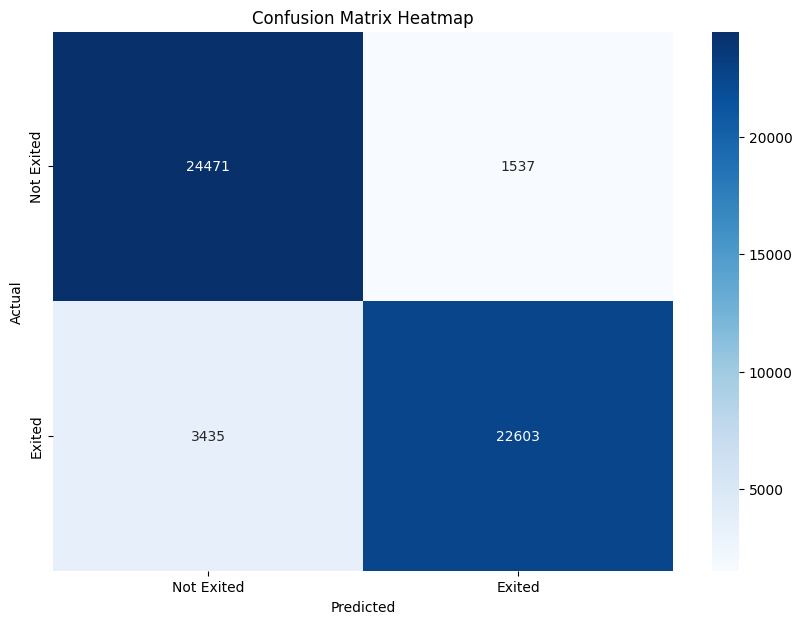

In [43]:
from sklearn.metrics import confusion_matrix
# Create the confusion matrix
conf_matrix = confusion_matrix(yTrue.cpu(), yPred.cpu())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()